In [1]:
# use jason's pre processed docs in the squlite DB
# for each triplet in triplets table
# desearlized pydantic triplet
# if subjet/Stratigraphy has t_unts (i.e. location data available, keeper)
# else not keeper

# for each keeper triplet:
#   subject and object have geolocation? (no -> not use bucket)
#   subject and object within cutoff distance of each other? (no -> not use bucket)
#   
# 
# get paragrpah from vectorDB w/ hash ID

# crate 

# open DB, get triplets in graphooutputs

In [33]:
import sqlite3
from datetime import datetime

# con = sqlite3.connect("data/triplets.db")
con = sqlite3.connect("data/data_dump_240430.db")
cur = con.cursor()

#get DB table schema
# res = cur.execute("""SELECT *
#   FROM sqlite_schema AS m
#  WHERE m.type='table'
#  ORDER BY 1;""")
# res.fetchone()

COLUMN_LOOKUP = { 
    'index': 0,
    'id': 1,
    "job_id": 2,
    "hashed_txt": 3,
    "paper_id": 4,
    "triplets": 5
}

res = cur.execute("""SELECT * FROM triplets;""")
triplet_db_tuples = res.fetchall()


In [40]:
triplet_db_tuples[0][COLUMN_LOOKUP['id']]

'5223e6aa-bcd9-4e32-b3f2-eaa070ef356e'

# create graphoutput objects - cram triplet db info into provenance

In [99]:
import asyncio
from typing import Any
from tqdm.auto import tqdm
from pydantic import ValidationError
from collections import Counter

from text2graph.schema import GraphOutput
from text2graph.geolocation.geocode import RateLimitedClient

def filter_triplet_db_tuples(triplet_db_tuples: list[tuple[Any, Any, Any, Any, Any]]) -> tuple[list[GraphOutput], list[int]]:
    """
    read db tuples, ignore those with no triplets and those with validation errs
    :param triplet_db_tuples: listof tuples from sqlite3 db triplet table
    :return: list of graphoutput objects, list of triplet_tuples indexes with validation errors
    """
    filtered_graphoutputs = []
    triplet_counts = []
    validation_error_indexes = []
    for i, graphoutput in tqdm(enumerate(triplet_db_tuples)):
        
        if not graphoutput[COLUMN_LOOKUP['triplets']]:
            continue
        try:
            go = GraphOutput.model_validate_json(graphoutput[COLUMN_LOOKUP['triplets']])
        except ValidationError:
            validation_error_indexes.append(i)
            continue
        
        if go.triplets:
            for triplet in go.triplets:
               triplet.provenance.additional_values["triplet_db"] = {
                 "triplet_db_pk": graphoutput[COLUMN_LOOKUP['id']], "paragraph_hash": COLUMN_LOOKUP['hashed_txt'], "xdd_id":graphoutput[COLUMN_LOOKUP['paper_id']] 
               }
            triplet_counts.append(len(go.triplets))
            filtered_graphoutputs.append(go)
    print(f"total_triplets_output: {sum(triplet_counts)}")
    return filtered_graphoutputs, validation_error_indexes

filtered_graphoutputs, validation_error_indexes = filter_triplet_db_tuples(triplet_db_tuples)
print(len(filtered_graphoutputs), len(validation_error_indexes))

0it [00:00, ?it/s]

total_triplets_output: 783856
153074 0


In [107]:
print(len(filtered_graphoutputs), len(validation_error_indexes))
print(
    f"number of pre-existing t_units entries (hydration check): "
    f"{sum([1 for go in filtered_graphoutputs for triplet in go.triplets if triplet.object.t_units and triplet.object.t_units > 0])}"
)
filtered_graphoutputs[1]

153074 0
number of pre-existing t_units entries (hydration check): 1


GraphOutput(triplets=[RelationshipTriplet(subject=Location(name='Australia', lat=None, lon=None, provenance=Provenance(id=UUID('ac501d4a-e290-4f95-8cd9-5369e244a9b2'), source_name='OpenSourceModel', source_url=None, source_version='mixtral', requested=datetime.datetime(2024, 4, 29, 16, 15, 39, 540622, tzinfo=datetime.timezone.utc), additional_values={'temperature': 0.0, 'prompt': 'v3', 'doc_ids': ['620c0c1fad0e9c819b020518']}, previous=None)), predicate='has', object=Stratigraphy(strat_name='gold reserves', strat_name_long=None, rank=None, strat_name_id=None, concept_id=None, bed=None, bed_id=None, mbr=None, mbr_id=None, fm=None, fm_id=None, subgp=None, subgp_id=None, gp=None, gp_id=None, sgp=None, sgp_id=None, b_age=None, t_age=None, b_period=None, t_period=None, c_interval=None, t_units=None, ref_id=None, lat=None, lon=None, provenance=Provenance(id=UUID('c3952bfc-09e0-41aa-b24c-2a90af2730b4'), source_name='OpenSourceModel', source_url=None, source_version='mixtral', requested=dateti

In [108]:
len(filtered_graphoutputs[::1000])

154

In [109]:
# hydrate subsample of filtered GraphOutputs, and test for keepers 
import logging

logging.basicConfig(level=logging.INFO)

keeper_triplets = []
not_keeper_triplets = []
keeper_counts = []
not_keeper_counts = []
for i, go in tqdm(enumerate(filtered_graphoutputs[::1000])):
    await go.hydrate(client=RateLimitedClient(interval=1.5))
    for triplet in go.triplets:
        if triplet.object.t_units and triplet.object.t_units >= 1:
            keeper_triplets.append(triplet)
        else:
            not_keeper_triplets.append(triplet)
    
    keeper_counts.append(len(keeper_triplets))
    not_keeper_counts.append(len(not_keeper_triplets))

print(f"keeper_counts: {sum(keeper_counts)}, not_keeper_counts: {sum(not_keeper_counts)}") 
    

0it [00:00, ?it/s]

ReadTimeout: 

In [110]:
print(f"keeper_counts: {sum(keeper_counts)}, not_keeper_counts: {sum(not_keeper_counts)}") 

keeper_counts: 80, not_keeper_counts: 3735


In [133]:
import pyproj
from text2graph.schema import RelationshipTriplet


def subject_object_distance(triplet: RelationshipTriplet, geod: pyproj.Geod = pyproj.Geod(ellps='WGS84')) -> float | None:
    if not triplet.object.lon or not triplet.object.lat or not triplet.subject.lon or not triplet.subject.lat:
        return None
    _, _, distance_in_meters = geod.inv(
                triplet.object.lon,triplet.object.lat, triplet.subject.lon, triplet.subject.lat
            )
    return distance_in_meters


def triplet_subject_object_within_distance_threshold(triplet: RelationshipTriplet, threshold_km: float | None = None) -> bool:
    if not threshold_km:
        threshold_km = 500 / 0.621371  # 500 mi
    
    distance_in_meters = subject_object_distance(triplet)
    if distance_in_meters and distance_in_meters / 1000 < threshold_km:
        return True
    
    else:
        return False
    
    
    

    

In [136]:
both_located_count = 0
for i, triplet in enumerate(keeper_triplets):
    if triplet_subject_object_within_distance_threshold(triplet):
        both_located_count += 1
        print(i)
        print(triplet.subject.name, triplet.subject.lat, triplet.subject.lon)
        print(triplet.object.strat_name, triplet.object.lat, triplet.object.lon)
        print(f"{subject_object_distance(triplet)/1000} km")
        print()
    else:
        pass
    
        
        
print(f"{both_located_count=}")
    

2
CanTech 43.5099594 -79.6329023
Sample 39.425 -86.241
714.1328970406075 km

4
Alberta 55.001251 -115.002136
Swan Hills 56.305 -121.468
431.9365265045756 km

both_located_count=2


In [122]:
keeper_triplets[4]

RelationshipTriplet(subject=Location(name='Alberta', lat='55.001251', lon='-115.002136', provenance=Provenance(id=UUID('c7b3fed8-425e-4f7a-8eb7-70e8f8e20c98'), source_name='GeocodeAPI', source_url='https://geocode.maps.co/search?&q=Alberta', source_version=None, requested=datetime.datetime(2024, 4, 30, 16, 54, 27, 716503), additional_values={}, previous=Provenance(id=UUID('a74690b8-99ff-4fac-8e31-0edab86611d5'), source_name='OpenSourceModel', source_url=None, source_version='mixtral', requested=datetime.datetime(2024, 4, 29, 16, 15, 39, 540622, tzinfo=datetime.timezone.utc), additional_values={'temperature': 0.0, 'prompt': 'v3', 'doc_ids': ['620d1066ad0e9c819b058301']}, previous=None))), predicate='is located in', object=Stratigraphy(strat_name='Swan Hills', strat_name_long='Swan Hills Formation', rank='Fm', strat_name_id=5996, concept_id=29699, bed='', bed_id=0, mbr='', mbr_id=0, fm='Swan Hills', fm_id=5996, subgp='', subgp_id=0, gp='Beaverhill Lake', gp_id=8154, sgp='', sgp_id=0, b_a

In [92]:
for i, triplet in enumerate(not_keeper_triplets):
    print(i, " ", triplet.subject.name, "\n\t", triplet.predicate, "\n\t", triplet.object.strat_name)
    

0   centre of the deposit 
	 MINERALOGICAL ZONING (CENTER) 
	 corundum-chlorite > spinel - chlorite > enstatite > talcose rock > friable dunite > dunite
1   rim of the deposit 
	 MINERALOGICAL ZONING (RIM) 
	 plumasite > biotitite > pegmatite > serpentinite
2   intermediate portion of the deposit 
	 MINERALOGICAL ZONING (INTERMEDIATE) 
	 aplite> plumasite>spinel-magnetite rock > vermiculite and/or chlorite > actinolite >talc>serpentinite
3   pegmatite may not be present 
	 MINERALOGICAL ZONING (BARREN) 
	 barren pegmatite> marundite > talc-chlorite zone>amphibolite
4   CH-33 
	 discovered by prospecting in an area of abundant kimberlite boulders and cobbles 
	 kimberlite
5   CH-33 
	 has an estimated surface expression of 
	 five hectares
6   CH-44 
	 discovered by RC drilling 
	 kimberlite
7   FS 
	 supportable by 
	 2019 resource estimate
8   FS 
	 development from 
	 previously reviewed 2017 and 2018 resource estimates
9   northern region 
	 can be used for refining 
	 tonnes and gr

In [123]:
# def create_graph_outputs(triplet_db_tuples: list[tuple[Any, Any, Any, Any, Any]]) -> tuple[list[GraphOutput], list[GraphOutput]]:
#     keepers = []
#     out_bucket = []
#     triplet_counts = []
#     keeper_counts = []
#     out_bucket_counts = []
#     validation_error_indexes = []
#     for i, graphoutput in tqdm(enumerate(triplet_db_tuples)):
#         if not graphoutput[COLUMN_LOOKUP['triplets']]:
#             continue
#         try:
#             go = GraphOutput.model_validate_json(graphoutput[COLUMN_LOOKUP['triplets']])
#         except ValidationError:
#             validation_error_indexes.append(i)
#             continue
#         triplet_counts.append(len(go.triplets))
#         keeper_triplets = []
#         outbucket_triplets = []
#         if go.triplets:
#             await go.hydrate(client=RateLimitedClient(interval=1.5))
#             for triplet in go.triplets:
#                 triplet.provenance.additional_values["triplet_db"] = {
#                     "triplet_db_pk": graphoutput[COLUMN_LOOKUP['id']], "paragraph_hash": COLUMN_LOOKUP['hashed_txt'], "xdd_id":graphoutput[COLUMN_LOOKUP['paper_id']] 
#                 }
#                 if triplet.object.t_units and triplet.object.t_units >= 1:
#                     keeper_triplets.append(triplet)
#                 else:
#                     outbucket_triplets.append(triplet)
# 
#             keeper_counts.append(len(keeper_triplets))
#             out_bucket_counts.append(len(outbucket_triplets))
#             if len(keeper_triplets) > 0:
#                 keeper_go = GraphOutput(triplets=keeper_triplets)
#                 keepers.append(keeper_go)
#             if len(outbucket_triplets) > 0:
#                 out_bucket_go = GraphOutput(triplets=outbucket_triplets)
#                 out_bucket.append(out_bucket_go)
# 
# 
#     count_counter = Counter(triplet_counts)
#     keeper_counter = Counter(keeper_counts)
#     out_bucket_counter = Counter(out_bucket_counts)
#     print(f"{out_bucket_counter=}")
#     print(f"{keeper_counter=}")
#     print(f"{sum([v for k, v in keeper_counter.items() if k != 0])=}")
#     print(f"validation error index ct: {len(validation_error_indexes)}")
#     print(f"validation error indexes: {validation_error_indexes}")
#     return keepers, out_bucket
# 
# keepers, out_bucket = create_graph_outputs(triplet_db_tuples[:10000])


# calculate distances between points if exist

In [9]:
from tqdm.auto import tqdm
import pyproj

from text2graph.geolocation.geocode import RateLimitedClient 

threshold_meters = 500 / 0.621371 * 1000  # 500 mi

correct = []
incorrect = []

geod = pyproj.Geod(ellps='WGS84')

client = RateLimitedClient(interval=1.5, count=1, timeout=30) 

for graphoutput in tqdm(keepers):
    await graphoutput.hydrate(client=client)
    for triplet in graphoutput.triplets:
        # print(triplet.object.strat_name_long, triplet.object.lat, triplet.object.lon) 
        # print(triplet.subject.name, triplet.subject.lat, triplet.subject.lon)
        distance_in_meters = None
        if triplet.object.lon and triplet.object.lat and triplet.subject.lon and triplet.subject.lat:
            _, _, distance_in_meters = geod.inv(
                triplet.object.lon,triplet.object.lat, triplet.subject.lon, triplet.subject.lat
            )
            # print(f"{distance_in_meters=}")
            if distance_in_meters <= threshold_meters:
                correct.append(triplet)
                continue
                
        incorrect.append(triplet)

print(f"total triplets: {sum([len(x.triplets) for x in keepers])}")
print(f"{len(correct)=}")
print(f"{len(incorrect)=}")


  0%|          | 0/41 [00:00<?, ?it/s]

total triplets: 63
len(correct)=4
len(incorrect)=59


In [10]:
print(f"total triplets: {sum([len(x.triplets) for x in keepers])}")
print(f"{len(correct)=}")
print(f"{len(incorrect)=}")

total triplets: 63
len(correct)=4
len(incorrect)=59


# eval incorrect

len(km_distances)=4


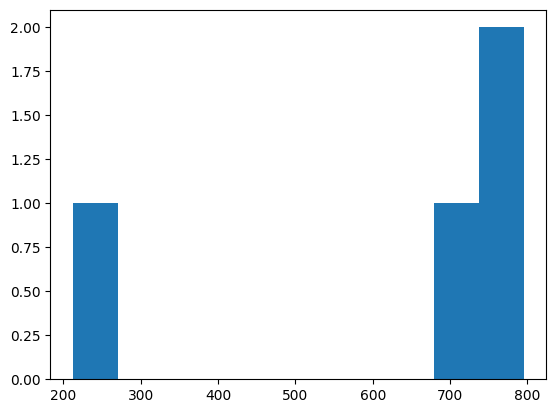

In [12]:
import matplotlib.pyplot as plt


triplet_km_tuples = [] 
for i, triplet in enumerate(correct):
    if triplet.subject.lat and triplet.object.lat:
        _, _, distance_in_meters = geod.inv(
            triplet.object.lon,triplet.object.lat, triplet.subject.lon, triplet.subject.lat
        )
        triplet_km_tuples.append((triplet, distance_in_meters / 1000))

km_distances = sorted([x[1] for x in triplet_km_tuples])
print(f"{len(km_distances)=}")
plt.hist(km_distances)
plt.show()

In [13]:
km_distances[:5]

[212.4893813433834, 682.3628427832246, 795.1683952262764, 795.517890661869]

In [49]:
import pandas as pd

pd.DataFrame(
        [
            (
                x[0].subject.name, 
                x[0].predicate, 
                x[0].object.strat_name_long, 
                x[1], 
                x[0].provenance.additional_values["triplet_db"]["paragraph_hash"],
                x[0].provenance.additional_values["triplet_db"]["xdd_id"]
            ) 
            for x in triplet_km_tuples if x[1] in km_distances[:5]
        ],
    columns=["subject", "predicate", "object", "distance", "paragraph_hash", "xdd_id"]
).sort_values(by="distance")

,subject,predicate,object,distance,paragraph_hash,xdd_id
3,Sept-Îles,has flights to,Quebec Group,212.489381,84b32395781f6e5898f66a6a4b6bb12a44997c3ff188b3...,6520b4ae4f5dbdaca31aaea9
2,Schefferville,operates flights from,Quebec Group,682.362843,84b32395781f6e5898f66a6a4b6bb12a44997c3ff188b3...,6520b4ae4f5dbdaca31aaea9
4,parts of Québec,Innu Nation may assert claims in and to,Quebec Group,795.168395,c6e1c82be4563d0d6cbbdb559bee48cf07982851af4011...,6520b4ae4f5dbdaca31aaea9
1,Hydro-Quebec,is located in or near,Quebec Group,795.517891,5efbdaa62e323613f7e91c465f26627cf0f37ec91ac334...,6520b4ae4f5dbdaca31aaea9
0,Rouyn-Noranda,located in the Province of,Quebec Group,1088.226905,b9f0b046a20f4051a871def3715ee233d8b88e2e3d20d8...,6520ab4f4f5dbdaca31a68da


In [45]:
triplet_km_tuples[0][0].provenance.additional_values["triplet_db"]

{'triplet_db_pk': '03c7b997-27c2-458c-a91c-6836bcd43f79',
 'paragraph_hash': 'b9f0b046a20f4051a871def3715ee233d8b88e2e3d20d8a11b4c083a5a689ed7',
 'xdd_id': '6520ab4f4f5dbdaca31a68da'}

In [90]:
print(keepers[n].triplets[0].object.strat_name_long, keepers[n].triplets[0].object.lat, keepers[n].triplets[0].object.lon) 
print(keepers[n].triplets[0].subject.name, keepers[n].triplets[0].subject.lat, keepers[n].triplets[0].subject.lon)

GraphOutput(triplets=[RelationshipTriplet(subject=Location(name='property', lat='47.36820575', lon='-93.37904373616992', provenance=Provenance(id=UUID('41a2371a-77a3-4725-9e05-965700a8f9a7'), source_name='GeocodeAPI', source_url='https://geocode.maps.co/search?&q=property', source_version=None, requested=datetime.datetime(2024, 4, 26, 11, 30, 39, 783271), additional_values={}, previous=Provenance(id=UUID('51e560a4-e203-48e0-8d34-0c9f537feece'), source_name='OpenSourceModel', source_url=None, source_version='mixtral', requested=datetime.datetime(2024, 4, 24, 21, 35, 23, 392241, tzinfo=datetime.timezone.utc), additional_values={'temperature': 0.0, 'prompt': 'v3', 'doc_ids': []}, previous=None))), predicate='legally surveyed prior to the issue of the mining concession', object=Stratigraphy(strat_name='Quebec', strat_name_long='Quebec Group', rank='Gp', strat_name_id=7947, concept_id=29319, bed='', bed_id=0, mbr='', mbr_id=0, fm='', fm_id=0, subgp='', subgp_id=0, gp='Quebec', gp_id=7947, s

In [98]:
import requests


def mean_and_stdev(l: list[float | int]) -> tuple[float, float]:
    """
    return mean and std dev of a list of numbers, ignores Nones
    if len(list) = 1, return only value and zero
    """
    l = [x for x in l if x]
    if len(l) == 1:
        return l[0], 0.
    mean = sum(l)/len(l)
    std_dev = sum([(x-mean)**2 for x in l])/(len(l)-1)
    return mean, std_dev


def strat_name_id_lat_lons(strat_name_id: int) -> tuple[list[float], list[float]] | tuple[None, None]:
    """
    retrieve all column lat lons from macrostrat for a given strat_name_id
    :param strat_name_id: macrostrat strat_name_id
    :return: lists of lats and lons 
    """
    url = f"https://macrostrat.org/api/columns?strat_name_id={strat_name_id}"
    r = requests.get(url)
    rj = r.json()
    lats = None
    lons = None
    if rj['success']['data']:
        lats = []
        lons = []
        for col in rj['success']['data']:
            lats.append(float(col["lat"]))
            lons.append(float(col["lng"]))    
    return lats, lons


strat_name_id = keepers[1].triplets[0].object.strat_name_id
lats, lons = strat_name_id_lat_lons(strat_name_id=strat_name_id)
print(f"{mean_and_stdev(lats)=}")
print(f"{mean_and_stdev(lons)=}")

        


mean_and_stdev(lats)=(48.56175, 0.372928916666665)
mean_and_stdev(lons)=(-66.56275000000001, 4.186016250000002)


<BarContainer object of 30 artists>

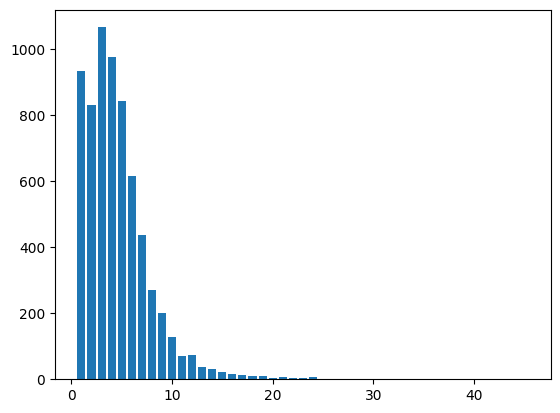

In [76]:
import matplotlib.pyplot as plt

plt.bar(out_bucket_counter.keys(), out_bucket_counter.values())

In [ ]:
for go in all_graph_outputs:
    for triplet in go.triplets:
        

In [54]:
from text2graph.schema import GraphOutput, RelationshipTriplet
go = GraphOutput.model_validate_json(triplet_db_tuple[3])
go.triplets[0].provenance.additional_values["triplet_db"] = {"triplet_db_pk": triplet_db_tuple[0], "paragraph_hash": triplet_db_tuple[1], "xdd_id":triplet_db_tuple[2] }
go.triplets[0].provenance.additional_values

{'temperature': 0.0,
 'prompt': 'v3',
 'doc_ids': [],
 'triplet_db': {'triplet_db_pk': '955616ce-f846-4665-9c64-d4709a34680d',
  'paragraph_hash': '19a82f930b2ced3767b49d6fa8235fb15831785ca26b10c5e0755c96408cf93e',
  'xdd_id': '6520ab4f4f5dbdaca31a68da'}}

In [41]:
await go.hydrate()
go.triplets[0]

RelationshipTriplet(subject=Location(name='some similarities with the Elder Mine', lat=None, lon=None, provenance=Provenance(id=UUID('8dcf7538-d314-4ba0-800a-08a4efb1782e'), source_name='OpenSourceModel', source_url=None, source_version='mixtral', requested=datetime.datetime(2024, 4, 24, 21, 35, 23, 392241, tzinfo=datetime.timezone.utc), additional_values={'temperature': 0.0, 'prompt': 'v3', 'doc_ids': []}, previous=None)), predicate='shares', object=Stratigraphy(strat_name='Elder', strat_name_long='Elder Subgroup', rank='SubGp', strat_name_id=92908, concept_id=30327, bed='', bed_id=0, mbr='', mbr_id=0, fm='', fm_id=0, subgp='Elder', subgp_id=92908, gp='Goose Hole', gp_id=85858, sgp='', sgp_id=0, b_age=511, t_age=485.4, b_period='Cambrian', t_period='Cambrian', c_interval='', t_units=0, ref_id=22, provenance=Provenance(id=UUID('b21871b2-3710-4b6c-9a51-0e696c86d5f7'), source_name='Macrostrat', source_url='https://macrostrat.org/api/defs/strat_names?strat_name_id=92908', source_version=2

In [13]:
import os
from dotenv import load_dotenv
import weaviate

load_dotenv()
weaviate_apikey = os.getenv("ASK_XDD_APIKEY")

client = weaviate.Client(
    "http://cosmos0001.chtc.wisc.edu:8080",
    auth_client_secret=weaviate.auth.AuthApiKey(weaviate_apikey),
)

hashed_text = "19a82f930b2ced3767b49d6fa8235fb15831785ca26b10c5e0755c96408cf93e"
where_filter = {
    "path": ["hashed_text"],
    "operator": "Equal",
    "valueText": hashed_text,
}
client.query.get("Paragraph", ["hashed_text", "text_content"]).with_where(
    where_filter
).do()

/usr/local/anaconda3/envs/usgs2023/lib/python3.11/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.25.3. The latest version is 4.5.6.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


{'data': {'Get': {'Paragraph': [{'hashed_text': '19a82f930b2ced3767b49d6fa8235fb15831785ca26b10c5e0755c96408cf93e',
     'text_content': 'ABCOURT purchased the property from the joint venture, the CDR Zone from Cambior and the Tagami property from AUNORE and Metall Mining Corp. ABCOURT reactivated the project from 1995 to 1998 and increased the mineral resources on the east end of the mine. The project was put on a care and maintenance basis after a sharp and steady decline of the price of gold in the fall of 1998.\nThe project is located 10 km northwest of Rouyn-Noranda and is easily accessible. Water and electric power are already available on the property. The mining plant is well equipped with its 2,606-feet deep 3-compartment, vertical shaft giving access to 16 levels. Substantial underground resources are still accessible and pre-production start-up may be initiated rapidly. The adjacent Tagami property covers very good gold targets sharing some similarities with the Elder Mine.'

In [16]:
from text2graph.geolocation.geocode import get_gps, RateLimitedClient

lat, lon, url = await get_gps(query="Madison, WI", client=RateLimitedClient(interval=1.5))

In [20]:
type(lat)

str

In [18]:
lon

'-89.3837613'

In [19]:
url

'https://geocode.maps.co/search?&q=Madison, WI'

In [25]:
from text2graph.alignment import AlignmentHandler

ah = AlignmentHandler()

TypeError: AlignmentHandler.__init__() missing 1 required positional argument: 'known_entity_names'